In [1]:
import time
t1 = time.time()

import math
import os
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam , SGD , Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import regularizers , initializers
from sklearn.metrics import confusion_matrix
import tensorflow.keras.backend as K
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

gpus = tf.config.experimental.list_physical_devices("GPU")
tf.config.set_visible_devices(gpus[1], "GPU")

2026-01-21 08:28:29.727738: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
##### load data #####

HLdata_path = "/root/data/data_HLfeature.h5"
HLdata_file = h5py.File(HLdata_path, 'r')
print(HLdata_file.keys())

LLdata_path = "/root/data/data_LLfeature.h5"
LLdata_file = h5py.File(LLdata_path, 'r')
print(LLdata_file.keys())

<KeysViewHDF5 ['BTag_leading', 'BTag_subleading', 'H_0', 'H_1', 'LB_1', 'M_JJ', 'S_0', 'S_1', 'X_HH', 'dEta_JJ', 'm_J_leading', 'm_J_subleading', 'missET', 'pT_JJ', 'pt_J_leading', 'pt_J_subleading', 'target_everytype', 'target_sigbg']>
<KeysViewHDF5 ['particle_info']>


In [3]:
##### include data #####

HLfeatures = ['BTag_leading', 'BTag_subleading', 'H_0', 'H_1', 'LB_1', 'M_JJ', 'S_0', 'S_1', 'X_HH', 'dEta_JJ', 'm_J_leading', 'm_J_subleading', 'missET', 'pT_JJ', 'pt_J_leading', 'pt_J_subleading']
LLfeatures = ['particle_info']

##### select BTag work point at WP70 (BitNumber 1) #####

BTag_leading = ((HLdata_file['BTag_leading'][:])&2)
BTag_subleading = ((HLdata_file['BTag_subleading'][:])&2)

##### include other high level features data #####

HLdata = []
for feature in HLfeatures:
    if feature=='BTag_leading': HLdata.append(BTag_leading)
    elif feature=='BTag_subleading': HLdata.append(BTag_subleading)
    else: HLdata.append(HLdata_file[feature][:])
HLdata = np.array(HLdata).T
print('shape of high level data:', HLdata.shape)

LLdata = LLdata_file['particle_info'][:]
print('shape of low level data:', LLdata.shape)

target = HLdata_file['target_sigbg'][:]
print('shape of target:', target.shape)

#### Do training data and validation data split #####

HL_train, HL_val, LL_train, LL_val, y_train, y_val = train_test_split(HLdata, LLdata, target, test_size=0.2, random_state=2330, shuffle=True)
print("\nAfter training validation data split:")
print("HL training data: ", HL_train.shape, "HL validation data: ", HL_val.shape)
print("LL training data: ", LL_train.shape, "LL validation data: ", LL_val.shape)
print("training target: ", y_train.shape, "validation target: ", y_val.shape)

shape of high level data: (733359, 16)
shape of low level data: (733359, 160)
shape of target: (733359,)

After training validation data split:
HL training data:  (586687, 16) HL validation data:  (146672, 16)
LL training data:  (586687, 160) LL validation data:  (146672, 160)
training target:  (586687,) validation target:  (146672,)


In [4]:
##### construct model #####

### high level features part ###

HL_input = layers.Input(shape=(16,), name='HL_Input')

x_hl = layers.Dense(128)(HL_input)
x_hl = layers.BatchNormalization()(x_hl)
x_hl = layers.Activation('relu')(x_hl)
x_hl = layers.Dropout(0.1)(x_hl)

x_hl = layers.Dense(128)(x_hl)
x_hl = layers.BatchNormalization()(x_hl)
x_hl = layers.Activation('relu')(x_hl)
x_hl = layers.Dropout(0.1)(x_hl)

### low level features part ###

LL_input = layers.Input(shape=(160,), name='LL_Input')

x_ll = layers.Dense(512)(LL_input)
x_ll = layers.BatchNormalization()(x_ll)
x_ll = layers.Activation('relu')(x_ll)
x_ll = layers.Dropout(0.1)(x_ll)

x_ll = layers.Dense(128)(x_ll)
x_ll = layers.BatchNormalization()(x_ll)
x_ll = layers.Activation('relu')(x_ll)
x_ll = layers.Dropout(0.1)(x_ll)

### combine two parts of model and the following node ###

combined = layers.Concatenate()([x_hl, x_ll])

x = layers.Dense(256, activation='relu')(combined)
x = layers.Dense(16, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid', name='Output')(x)

model = models.Model(inputs=[HL_input, LL_input], outputs=output)

### optimizer ###

opt = keras.optimizers.Adam(learning_rate=1e-5)

### compile ###

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy","mse"])

### summary ###

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 HL_Input (InputLayer)       [(None, 16)]                 0         []                            
                                                                                                  
 LL_Input (InputLayer)       [(None, 160)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 128)                  2176      ['HL_Input[0][0]']            
                                                                                                  
 dense_2 (Dense)             (None, 512)                  82432     ['LL_Input[0][0]']            
                                                                                              

2026-01-21 08:28:33.687813: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46696 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:25:00.0, compute capability: 8.6


In [5]:
##### training model #####

tr_model = model.fit(x=[HL_train, LL_train], y=y_train, validation_data=([HL_val, LL_val], y_val), epochs=150, batch_size=512, verbose=1)

Epoch 1/150


2026-01-21 08:28:38.506002: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2026-01-21 08:28:38.512245: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9708013240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-21 08:28:38.512292: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2026-01-21 08:28:38.520545: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-21 08:28:38.889037: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2026-01-21 08:28:39.008653: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

1146/1146 [==============================] - 17s 9ms/step - loss: 0.4137 - accuracy: 0.8042 - mse: 0.1342 - val_loss: 0.2772 - val_accuracy: 0.8802 - val_mse: 0.0852
Epoch 2/150
1146/1146 [==============================] - 10s 9ms/step - loss: 0.2199 - accuracy: 0.9121 - mse: 0.0654 - val_loss: 0.1479 - val_accuracy: 0.9465 - val_mse: 0.0415
Epoch 3/150
1146/1146 [==============================] - 10s 9ms/step - loss: 0.1639 - accuracy: 0.9379 - mse: 0.0471 - val_loss: 0.1247 - val_accuracy: 0.9558 - val_mse: 0.0345
Epoch 4/150
1146/1146 [==============================] - 10s 9ms/step - loss: 0.1449 - accuracy: 0.9461 - mse: 0.0411 - val_loss: 0.1139 - val_accuracy: 0.9598 - val_mse: 0.0313
Epoch 5/150
1146/1146 [==============================] - 11s 9ms/step - loss: 0.1326 - accuracy: 0.9515 - mse: 0.0373 - val_loss: 0.1059 - val_accuracy: 0.9630 - val_mse: 0.0290
Epoch 6/150
1146/1146 [==============================] - 11s 9ms/step - loss: 0.1238 - accuracy: 0.9548 - mse: 0.0347 - va

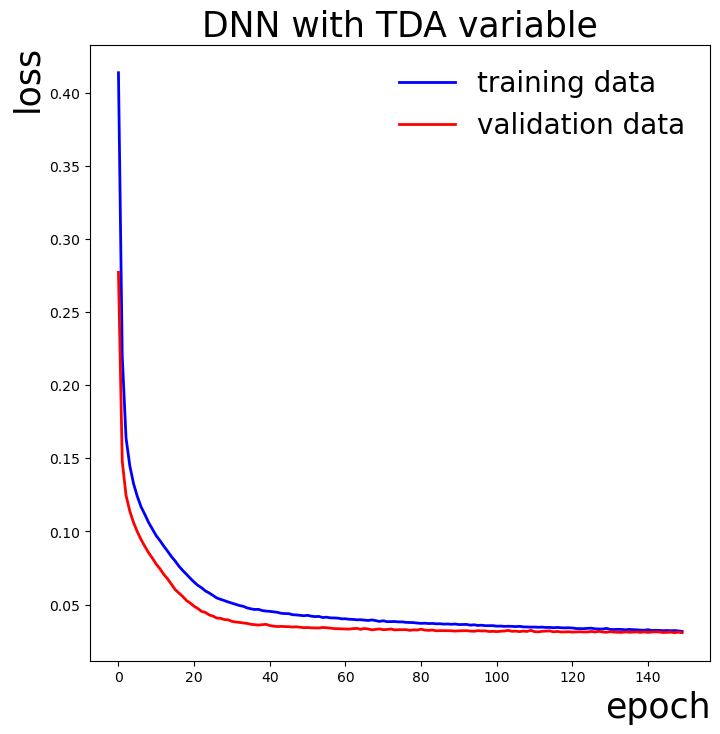

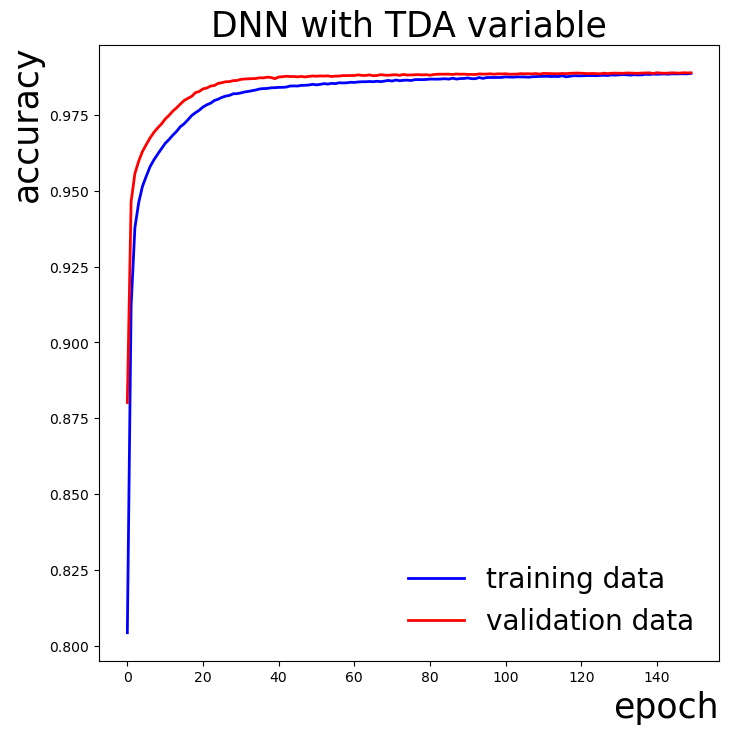

In [6]:
### plot learning curve

fig, ax = plt.subplots(1,1, figsize=(8,8))
plt.plot(tr_model.history["loss"], label='training data',c='blue',linewidth = 2)
plt.plot(tr_model.history["val_loss"], label='validation data',c='red',linewidth = 2)
plt.title("DNN with TDA variable", fontsize=25)
ax.set_ylabel('loss', fontsize=25,horizontalalignment='right',y=1)
ax.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
# plt.yscale("log")
plt.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)
plt.show()

fig, ax = plt.subplots(1,1, figsize=(8,8))
plt.plot(tr_model.history["accuracy"], label='training data',c='blue',linewidth = 2)
plt.plot(tr_model.history["val_accuracy"], label='validation data',c='red',linewidth = 2)
plt.title("DNN with TDA variable", fontsize=25)
ax.set_ylabel('accuracy', fontsize=25,horizontalalignment='right',y=1)
ax.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
# plt.yscale("log")
plt.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)
plt.show()

In [7]:
print("Time:{:^8.4f}(s)".format(time.time()-t1))

Time:1519.4763(s)


In [10]:
### save the model ###

model.save("/root/data/model_mucollider_v1.h5")

In [30]:
### model test ###

HLtest = []
LLtest = []
targettest = []
prediction = []

processes = ["hhvv", "hhmumu", "jjBG_ptcut", "ttBG_ptcut", "bbBG_ptcut", "wwBG", "wwvvBG", "zzBG", "zzvvBG"]
event_num = [147518, 143791, 35834, 35591, 39064, 50582, 99709, 60870, 120594]
Xsection = [4.0360050e-02, +3.3945676e-03, 1.345150e+01, 4.423600e+00, 2.325600e+00, 1.506969e+02, 1.224052e+01, 9.618000e+00, 6.473005e+00]     ### unit: fb
simulation_num = 500000
Luminosity = 1000   ### unit: fb^-1

count = 0
for process in processes:
    HLtest.append(HLdata[count:count+event_num[processes.index(process)]])
    LLtest.append(LLdata[count:count+event_num[processes.index(process)]])
    targettest.append(target[count:count+event_num[processes.index(process)]])
    prediction.append(model.predict([HLtest[-1], LLtest[-1]]))
    count += event_num[processes.index(process)]

3763/3763 [==============================] - 7s 2ms/step


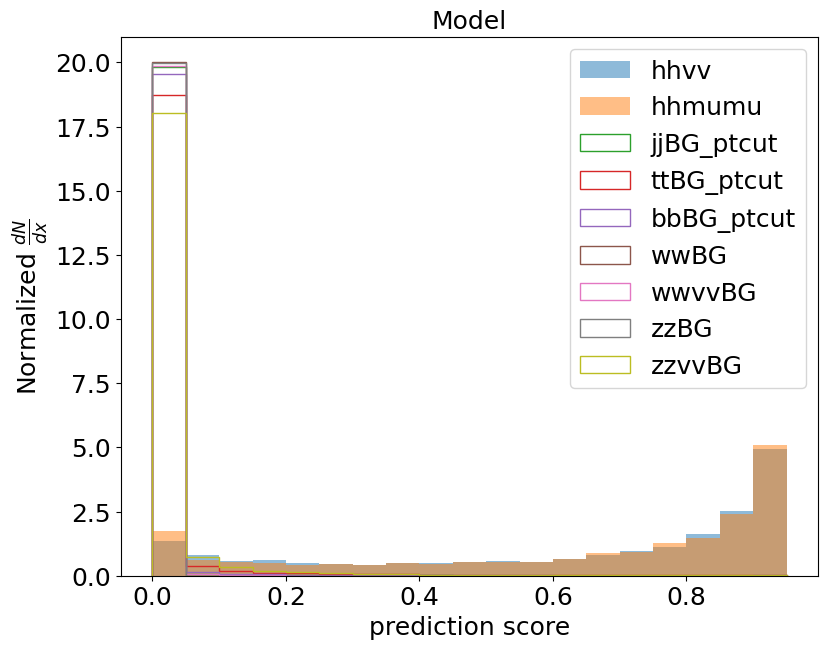

In [31]:
##### plot the prediction histogram #####

plt.figure(1, figsize=(9,7))
bins = np.arange(0,1,0.05)
for process in processes:
    plt.hist(prediction[processes.index(process)], bins=bins, label=process, histtype=('stepfilled' if (process=='hhvv' or process=='hhmumu') else 'step'), density=True, alpha=(0.5 if (process=='hhvv' or process=='hhmumu') else 1))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"prediction score", fontsize=18)
plt.ylabel(r"Normalized $\frac{dN}{dx}$", fontsize=18)
plt.title("Model", fontsize=18)
plt.legend(loc='best', fontsize=18)
plt.show()

In [49]:
### Do the score cut ###

score_cuts = [0.5, 0.7, 0.8, 0.9, 0.99, 0.999]

for score_cut in score_cuts:
    print("In score cut", score_cut)

    num_afterML = []
    for process in processes: num_afterML.append(sum(prediction[processes.index(process)]>=score_cut)[0])
    print("Number before ML: ", event_num)
    print("Number after  ML: ", num_afterML)
    
    ### calculate significance ###
    
    s, b = 0, 0
    for process in processes[0:2]:
        s += Luminosity * Xsection[processes.index(process)] * (num_afterML[processes.index(process)]/simulation_num)
    for process in processes[2:]:
        b += Luminosity * Xsection[processes.index(process)] * (num_afterML[processes.index(process)]/simulation_num)
        
    def significance(s,b):
        return np.sqrt(2*((s+b)*np.log(1+s/b)-s))
    
    z = significance(s,b)
    print("signal events:", s)
    print("background events:", b)
    print("significance:", z)
    print("\n")

In score cut 0.5
Number before ML:  [147518, 143791, 35834, 35591, 39064, 50582, 99709, 60870, 120594]
Number after  ML:  [144781, 142029, 48, 638, 142, 0, 140, 4, 1697]
signal events: 12.6509908814208
background events: 33.06999657
significance: 2.0781986955529654


In score cut 0.7
Number before ML:  [147518, 143791, 35834, 35591, 39064, 50582, 99709, 60870, 120594]
Number after  ML:  [143638, 141287, 26, 408, 73, 0, 105, 2, 972]
signal events: 12.5536902688024
background events: 19.84117612
significance: 2.5797627737051623


In score cut 0.8
Number before ML:  [147518, 143791, 35834, 35591, 39064, 50582, 99709, 60870, 120594]
Number after  ML:  [142724, 140660, 20, 285, 52, 0, 87, 2, 646]
signal events: 12.475655309632
background events: 13.83281934
significance: 2.978815959430004


In score cut 0.9
Number before ML:  [147518, 143791, 35834, 35591, 39064, 50582, 99709, 60870, 120594]
Number after  ML:  [140902, 139552, 10, 163, 32, 0, 64, 2, 356]
signal events: 12.3210609256304
back